## Problem Statement

The primary problem to address is to gain comprehensive insights into the demographics of anime fans and industry trends and to develop a effective item-based recommendation system for animes.

In [1]:
#Importing Basic Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

# Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#Modules for Hypothesis Testing
from scipy import stats

#Modules for GUI
import pandas as pd
import tkinter as tk
from tkinter import messagebox
from tkhtmlview import HTMLLabel

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

pd.set_option('display.width', 1000)

In [2]:
#Importing Data
user_data = pd.read_csv('users_cleaned.csv', low_memory = False)
anime_data = pd.read_csv('anime_cleaned.csv', low_memory = False)
anime_list = pd.read_csv('animelists_cleaned.csv', low_memory = False)

## Dataset Description 
anime_cleaned.csv: This file provides detailed information on individual anime, including title, synonyms, genre, studio, licensor, producer, duration, rating, score, airing date, episodes, source (manga, light novel, etc.), and various other relevant data. The dataset covers 14,478 unique anime, offering substantial insights into trends over time.

users_cleaned.csv: Focusing on users who watch anime, this file contains essential demographic data such as username, registration date, last online date, birth date, gender, location, and aggregated values from their anime lists. With 302,675 unique users, it enables a thorough analysis of user behavior and preferences.

animelist_cleaned.csv: Detailing anime lists for all users, this file includes information on the username, anime ID, score, status, and the timestamp when the record was last updated. With 80,076,112 records, including 46,358,322 with ratings, it forms the basis for understanding user engagement with anime titles.



In [3]:
user_rating = anime_list[['username', 'anime_id', 'my_score', 'my_status']]

In [4]:
anime_rating = anime_data.merge(user_rating, on = ['anime_id', 'anime_id'])

In [5]:
#This shows the different types of animes in the dataset
tips = px.data.tips()
fig = px.histogram(anime_data, y="type", orientation="h").update_xaxes(categoryorder='total ascending', title = "Types of Anime")
fig.show()

Based on the graph, we can see that TV-shows are the most common type of anime with 2980 different shows aired between 1942 and 2018 which accounts for 44.69% of all animes in the dataset

In [6]:
fig = px.histogram(anime_data, x="aired_from_year", 
                   title = 'Number of animes aired through the years')
fig.show()

From the Graph we can see that the highest number of the animes were aired in the year 2016. Apart from that we can also see that there is a gradual increment in the number of animes aired over the years but there is a sudden drop in the years 2017 and 2018.

In [7]:
# Create a scatter plot
fig = px.scatter(anime_data, x = 'score', y = 'scored_by', 
                 labels = {'Score':'Overall Score', 'Members':'Number of Scores'}, 
                 title = 'Anime Score vs. Number of Scores')

fig.show()

This graph shows the distribution of scores for various anime with the number of users that rated it so. This shows that the distribution is skewed to the right indicating most the of the shows are rated highly by the users


In [8]:
fig = px.histogram(anime_data, x="score", title = 'Anime Scores VS Count of Scores')
fig.show()

The graph shows the distribution of the scores for all the anime titles in the dataset. The scores follow a nornmal distribution that is skewed to the right. This indicates that a large number of animes are rated between 6-8 with 2 peaks at 6.5 and 7.5 (approx).

In [9]:
MRPU = user_data[['username', 'user_id', 'stats_mean_score']]

In [10]:
anime_with_mean_ratings = anime_list.merge(MRPU, on = ['username', 'username'])

In [11]:
anime_with_mean_ratings = anime_with_mean_ratings[['username', 'anime_id', 'user_id', 
                                                   'my_score', 'stats_mean_score']]
anime_with_mean_ratings = anime_with_mean_ratings.merge(anime_data, how = 'left', on = ['anime_id', 'anime_id'])

anime_with_mean_ratings = anime_with_mean_ratings[['username', 'anime_id', 'user_id', 
                                                   'my_score', 'stats_mean_score', 'title', 'genre']]

In [12]:
cross_tab = pd.crosstab(anime_with_mean_ratings['user_id'], anime_with_mean_ratings['title'])
#cross_tab.head()

In [13]:
cross_tab.shape

(108710, 6668)

In [14]:
pca = PCA(n_components = 3)
pca.fit(cross_tab)
pca_crosstab = pca.transform(cross_tab)
cluster = pd.DataFrame(pca_crosstab)

By utilizing PCA, we were able to extract the most significant features in a plottable format. We opted to utilize three components in an effort to maintain the maximum amount of information while minimizing its volume.

<Figure size 1600x900 with 0 Axes>

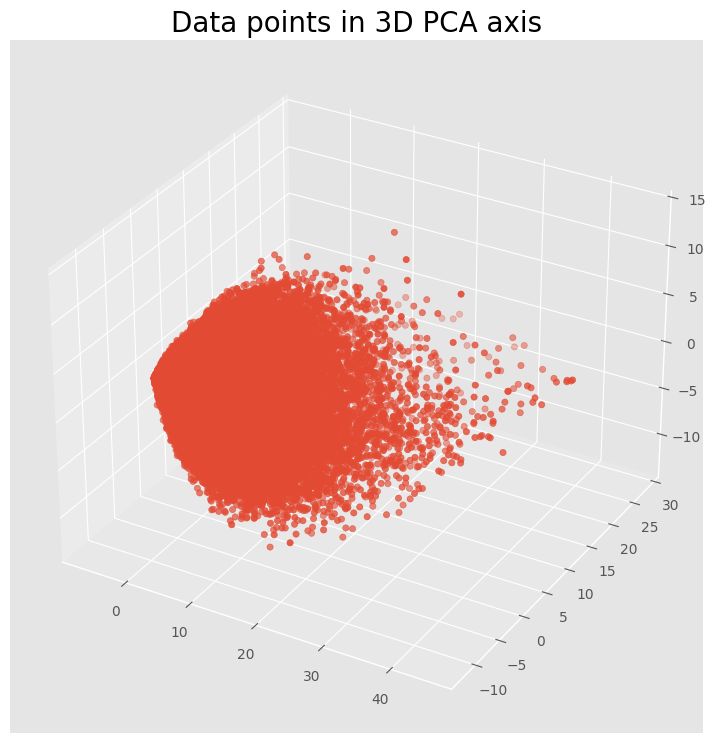

In [15]:
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
fig = plt.figure()
ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster[0], cluster[1], cluster[2])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

The elbow method involves plotting the number of clusters against the corresponding WCSS values. The plot typically resembles an arm, and the "elbow" point on the plot represents the optimal number of clusters. This point is where the incremental gain in clustering quality starts to diminish significantly, resulting in a less pronounced decrease in WCSS.

By using the elbow method, we can visually identify the number of clusters that provides a good balance between minimizing within-cluster sum of squares (WCSS) and avoiding overfitting. It helps us avoid underfitting (too few clusters) or overfitting (too many clusters) the data, leading to more meaningful and interpretable clustering results.

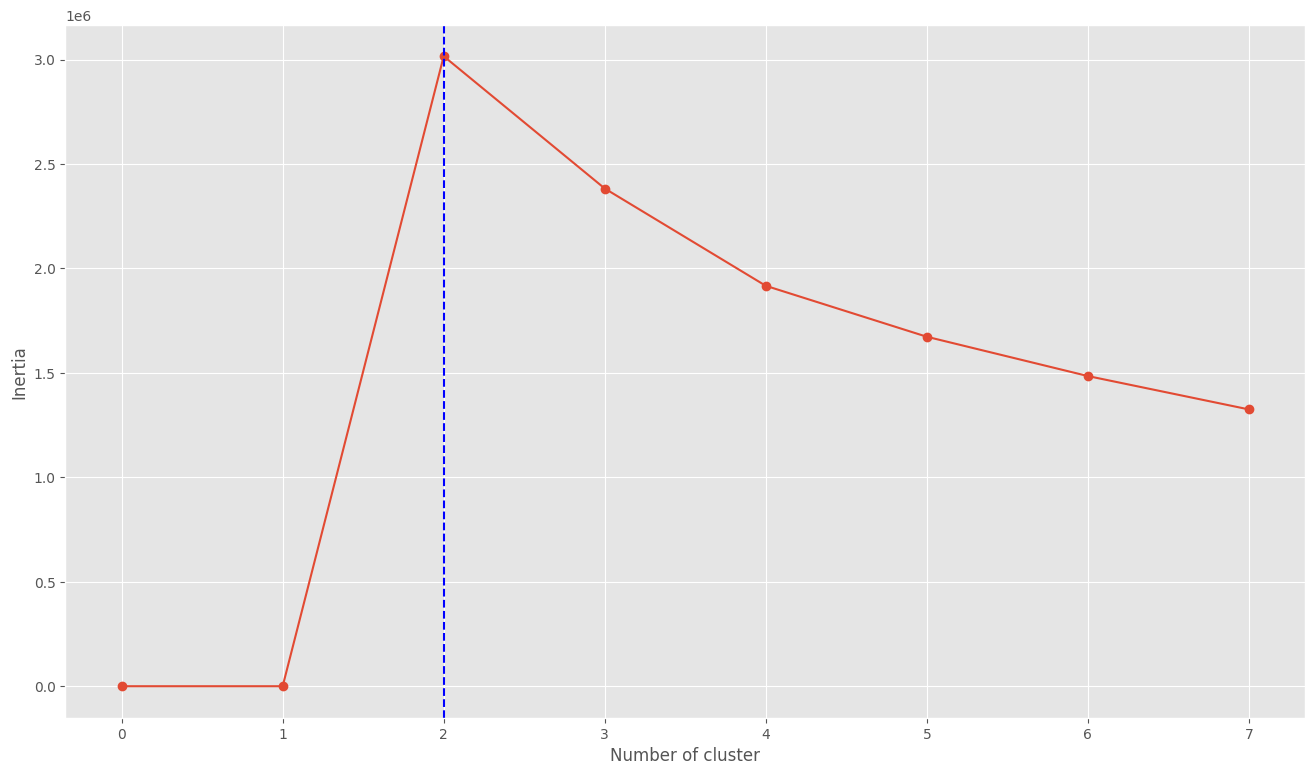

In [16]:
scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(cluster, kmeans.labels_))
    
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x = 2, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

Based on the "inertia graph", we can see the elbow point is 2 clusters, so we will divide the dataset into 2 clusters of users.

In [17]:
clusterer = KMeans(n_clusters = 2,random_state = 272).fit(cluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(cluster)

<Figure size 1600x900 with 0 Axes>

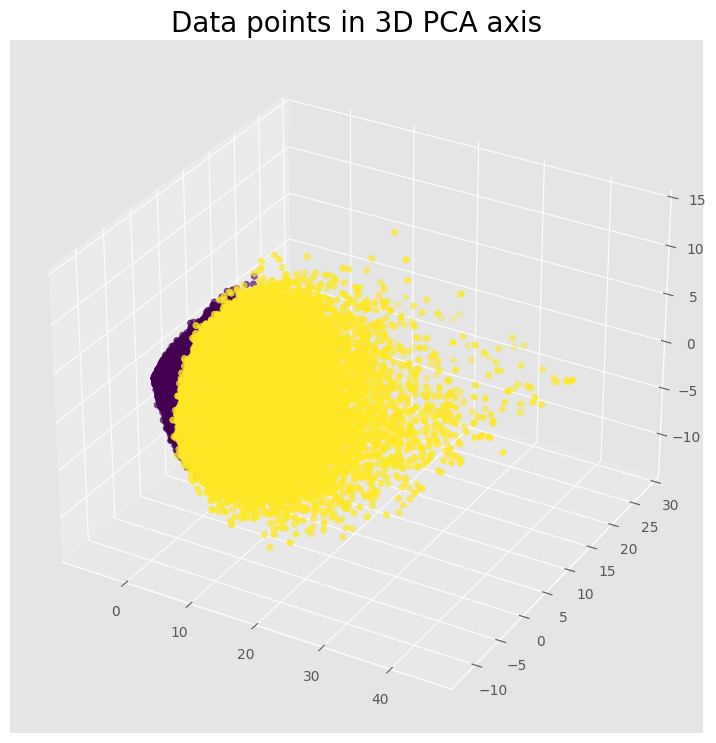

In [18]:
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
fig = plt.figure()
ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster[0], cluster[1], cluster[2], c = c_preds)

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

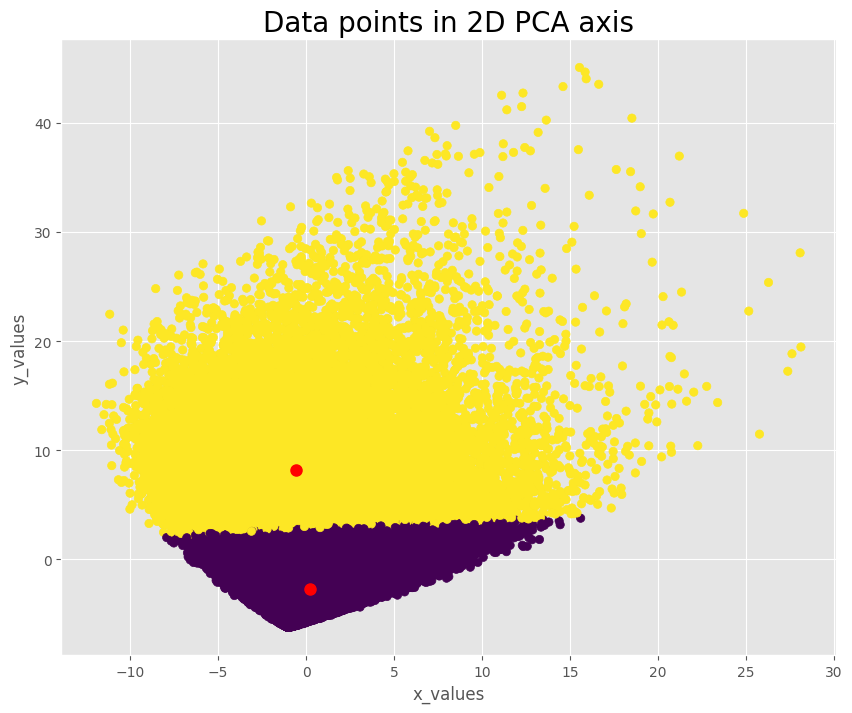

In [19]:
fig = plt.figure(figsize=(10,8))
plt.scatter(cluster[1], cluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

The separation between the clusters indicates the effectiveness of the clustering algorithm in identifying distinct user segments based on their anime watching patterns. The red dots represent the centroids of each cluster, showing the average position of users in the cluster. Users are clearly divided into two groups, reinforcing the idea of meaningful segmentation.

To analyze the interaction between users and anime titles we are creating a crosstabulation dataframe. It helps in understanding how users have rated different anime titles, providing insights into user preferences and the popularity of specific titles. The resulting cross_tab DataFrame can be used for collaborative filtering, recommendation systems, and other analyses related to user-item interactions.

In [20]:
cross_tab['user_id'] = cross_tab.index
cross_tab['cluster'] = c_preds

In [21]:
merged_data = user_data.merge(cross_tab[['cluster']], on = 'user_id', how = 'left', suffixes = ('', '_y'))

In [22]:
cluster_0_users = merged_data[merged_data['cluster'] == 0]
cluster_1_users = merged_data[merged_data['cluster'] == 1]

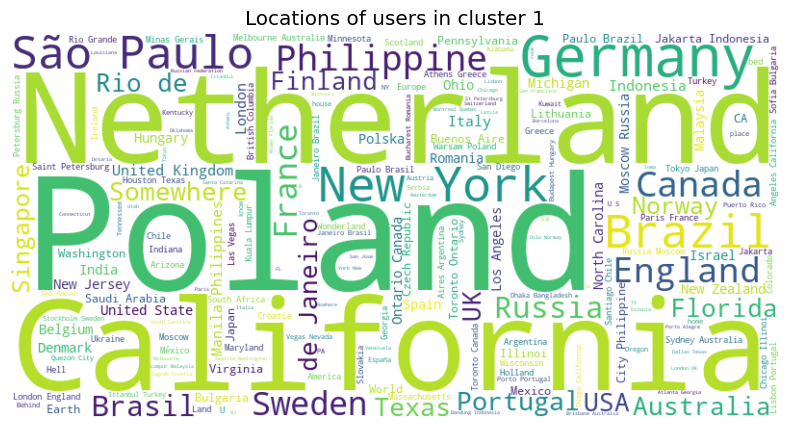

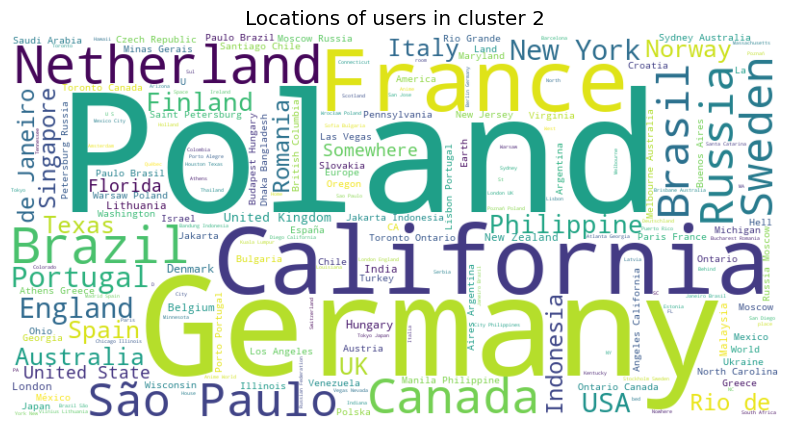

In [23]:
# Get the location data for cluster 0 users
cluster_0_locations = cluster_0_users['location'].astype(str)

# Combine all the location strings into a single string
all_locations = ' '.join(cluster_0_locations)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_locations)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.title('Locations of users in cluster 1')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##############################################################################################

# Get the location data for cluster 1 users
cluster_1_locations = cluster_1_users['location'].astype(str)

# Combine all the location strings into a single string
all_locations_1 = ' '.join(cluster_1_locations)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_locations_1)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.title('Locations of users in cluster 2')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


we can deduce that the most of the anime watching users from cluster 1 are from California, Poland Netherlands, Germany, and New York. This can help the content creators or marketers to tailor their offerings to suit the preferences of users in these regions.

we can deduce that the most of the anime watching users from cluster 2 are from California, Poland, Germany, France and Netherlands. This can help the content creators or marketers to tailor their offerings to suit the preferences of users in these regions.


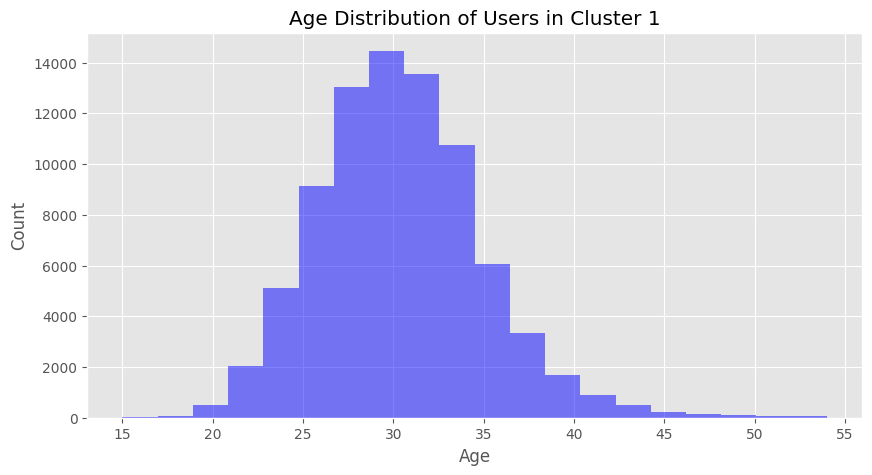

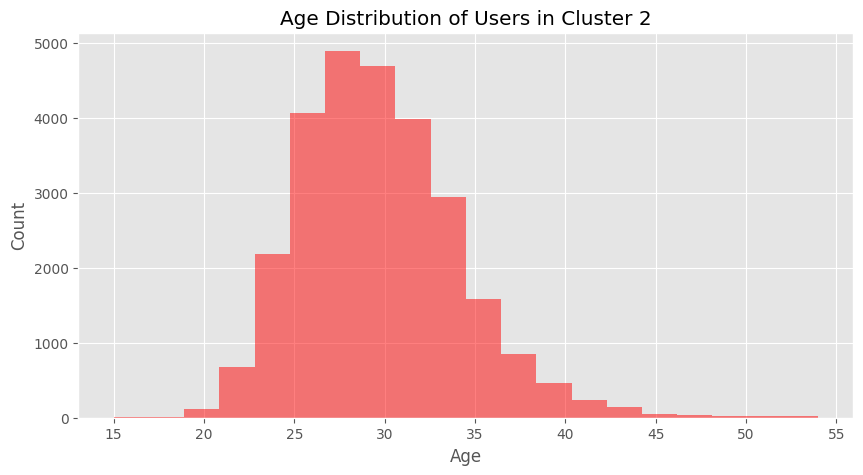

In [24]:
# Get the age of users in cluster 0
cluster_0_age = pd.to_datetime(cluster_0_users['birth_date']).apply(lambda x: (pd.Timestamp.now().date() - x.date()).days // 365)

# Get the age of users in cluster 1
cluster_1_age = pd.to_datetime(cluster_1_users['birth_date']).apply(lambda x: (pd.Timestamp.now().date() - x.date()).days // 365)

# Create a histogram plot for cluster 0
plt.figure(figsize=(10, 5))
plt.hist(cluster_0_age, bins=20, color='blue', alpha=0.5)
plt.title('Age Distribution of Users in Cluster 1')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

##############################################################################################

# Create a histogram plot for cluster 1
plt.figure(figsize=(10, 5))
plt.hist(cluster_1_age, bins=20, color='red', alpha=0.5)
plt.title('Age Distribution of Users in Cluster 2')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


This is to compare the age distribution patterns between users in Cluster 1 and Cluster 2. The histograms visually display the frequency of users within specified age bins. Both the clusters have a mean 29-30 years, but in cluster 1:user count is 14000 approx whereas, in cluster 2, the count is 5000 approx. The graph is skewed towards the left indicating the majority of the users are of young age (<30)


gender
Male          49802
Female        31634
Non-Binary      326
Name: count, dtype: int64


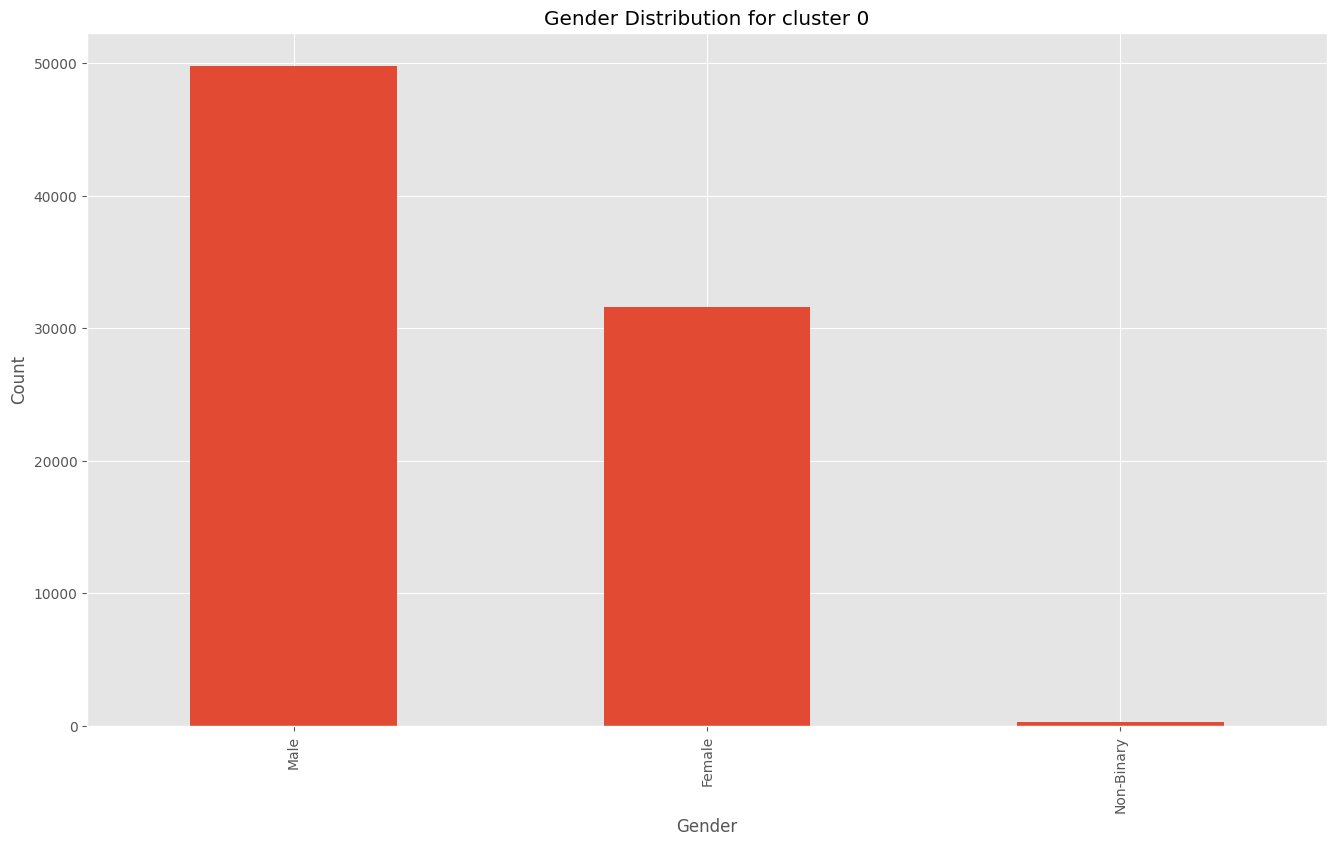

In [25]:
gender_distribution = cluster_0_users['gender'].value_counts()
print(gender_distribution)

gender_distribution.plot(kind='bar')
plt.title('Gender Distribution for cluster 0')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


gender
Male          21077
Female         5696
Non-Binary      175
Name: count, dtype: int64


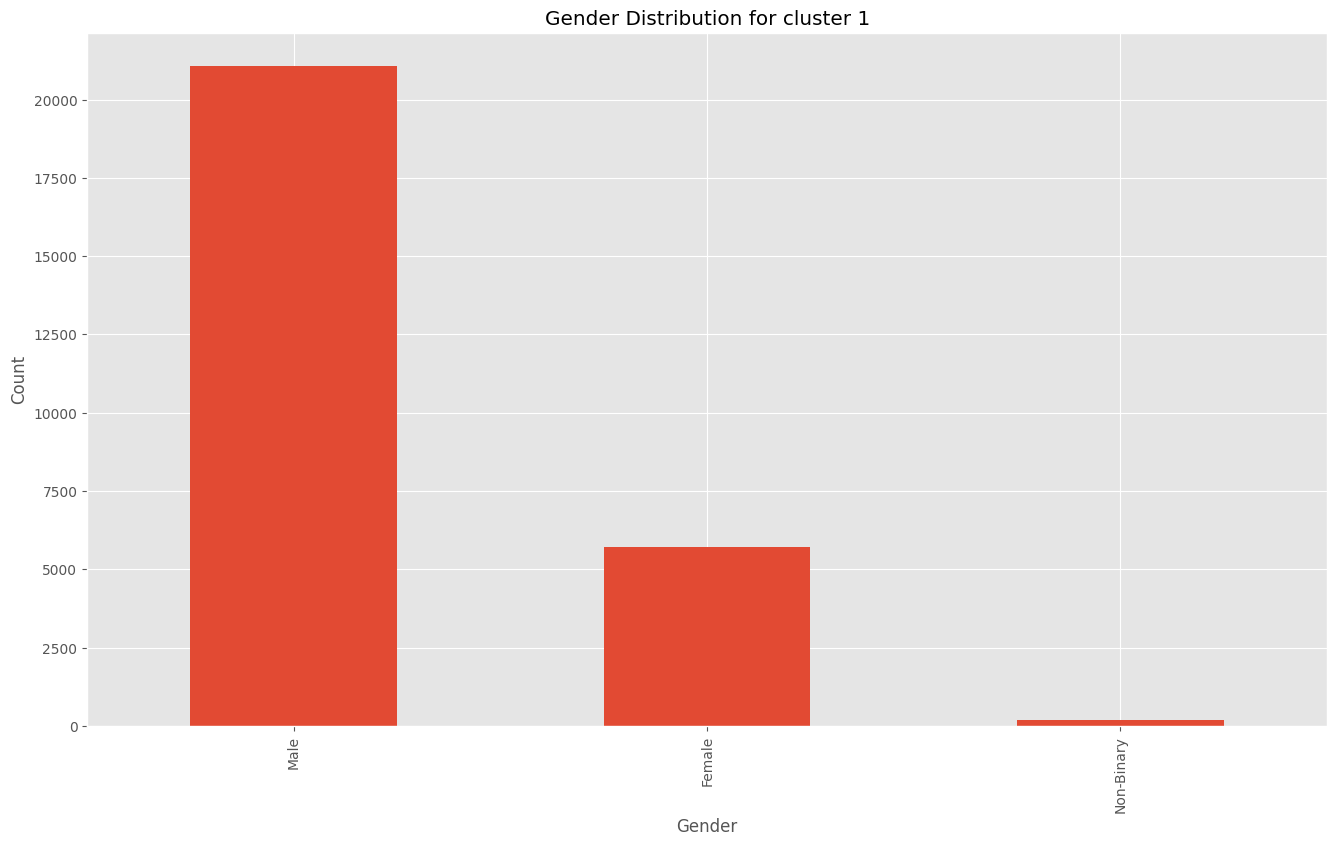

In [26]:
gender_distribution = cluster_1_users['gender'].value_counts()
print(gender_distribution)

gender_distribution.plot(kind='bar')
plt.title('Gender Distribution for cluster 1')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


The majority of users in this cluster belong to the "Male" category, with 49,802 individuals.The "Female" category follows, with 31,634 users and the "Non-Binary" category has the smallest count of 326 users. Compared to the cluster 1, this cluster 2 exhibits a different gender distribution. The "Male" category still has the highest count of 21,077 users, but it is lower than the previous cluster. The "Female" category also has a lower count of 5,696 users, compared to the previous cluster.And the count for the "Non-Binary" category is the smallest with 175 users



In [27]:
data = anime_with_mean_ratings[['username', 'anime_id', 'user_id', 'my_score']]

In [28]:
# Checking if there are any duplicate rows
duplicated_rows = data[data.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [username, anime_id, user_id, my_score]
Index: []


In [29]:
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# MinMaxScaler was used to normalize the 'my_score' column in the data scaling its values between 0 and 1. 

# Scale the 'my_score' column between 0 and 1
data['scaled_score'] = scaler.fit_transform(data[['my_score']])


Label encoding is a method of converting categorical variables into numerical form. It assigns each unique category in a categorical variable a unique integer.

First, a `LabelEncoder` object, `user_encoder`, is created. This object is then fit to the 'user_id' column of the `data` DataFrame, transforming the user IDs into integers. The transformed IDs are stored in a new column in the DataFrame, 'user_encoded'. The number of unique users is then calculated by finding the length of the classes_ attribute of the `user_encoder`, which contains the unique categories, and stored in `num_users`.

The same process is then repeated for the anime IDs. Another `LabelEncoder` object, `anime_encoder`, is created and fit to the 'anime_id' column of the `data` DataFrame. The transformed IDs are stored in a new column, 'anime_encoded', and the number of unique animes is calculated and stored in `num_animes`.

In [30]:
## Encoding user IDs
user_encoder = LabelEncoder()
data["user_encoded"] = user_encoder.fit_transform(data["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
data["anime_encoded"] = anime_encoder.fit_transform(data["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}".format(num_users))
print("Number of unique animes: {}".format(num_animes))
print("Minimum rating: {}".format(min(data['my_score'])))
print("Maximum Rating {}".format(max(data['my_score'])))


Number of unique users: 108710
Number of unique animes: 6668
Minimum rating: 0
Maximum Rating 10


In [31]:
# Shuffle the dataset
data = shuffle(data, random_state = 272)

# Create feature matrix X and target variable y
X = data[['user_encoded', 'anime_encoded']].values
y = data["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (31284030, 2)
Shape of y: (31284030,)


In [32]:
test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_set_size, random_state = 272)

In [33]:
def RecommenderNet(num_users, num_animes, embedding_size = 128):
    # User input layer and embedding layer
    user = Input(name = 'user_encoded', shape = [1])
    user_embedding = Embedding(name = 'user_embedding', input_dim = num_users, output_dim = embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name = 'anime_encoded', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding', input_dim = num_animes, output_dim = embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation = 'relu')(flattened)
    output = Dense(1, activation = 'sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs = [user, anime], outputs=output)
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ["mae", "mse"])
    
    return model

model = RecommenderNet(num_users, num_animes)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_encoded (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 anime_encoded (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               1391488   ['user_encoded[0][0]']        
                                                          0                                       
                                                                                                  
 anime_embedding (Embedding  (None, 1, 128)               853504    ['anime_encoded[0][0]']   

The function accepts 'num_users,' 'num_animes,' and 'embedding_size' as parameters. The values 'num_users' and 'num_animes' represent, correspondingly, the total number of unique users and animes in the dataset. "embedding_size" is the default value of 128 for the size of the embedding vectors.

Constructing the model utilizing the functional API of Keras. Two input layers are initially defined: one for users and one for animes. After every input layer is an embedding layer, which applies a density transformation to the input by converting it into fixed-size dense vectors. The acquisition of these dense vectors occurs through training.

It is then possible to compute the dot product between the anime embeddings and the user. This dot product symbolizes the user's interaction with an anime. 'True' is the value of the 'normalize' parameter, which divides the dot product by the product of the user's and anime embeddings' L2 norms. The consequence is a cosine similarity measure, a widely employed similarity metric in recommendation systems.

The dot product is subsequently transformed into a one-dimensional tensor by means of the 'Flatten' layer. The compressed tensor undergoes a dense layer operation with 64 units and a ReLU activation function. By passing the output of this dense layer through another dense layer with a sigmoid activation function and a unit, the output is again compressed. By limiting the output to a range of 0 to 1, the sigmoid activation function guarantees that the model is appropriate for a rating prediction task.

The output of the final dense layer and the user and anime inputs are subsequently used to construct the model via the 'Model' class. Additional metrics include mean absolute error and mean squared error, in addition to the Adam optimizer with a learning rate of 0.001 and the binary cross-entropy loss function utilized in the model's compilation.

After creating a model instance, a summary of that instance is output. The summary comprises the model's layers, the shape of the output for each layer, and the total number of parameters.

In [34]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose = 0)

# File path for saving the model weights
checkpoint_filepath = 'weights.txt'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only = True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only = True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience = 3, monitor = 'val_loss', mode = 'min', restore_best_weights = True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

The initiation phase involves establishing the initial, minimum, and maximum learning rates, in addition to the sample size for training. Assigning a specific value to the learning rate for each weight update in response to the estimated error is a hyperparameter that governs the degree of model modification.

Additionally specified are the epoch counts for the ramp-up, sustain, and exponential decay stages of the learning rate schedule. An epoch refers to a single iteration over the entirety of the training dataset.

In accordance with the schedule, the 'lrfn' function establishes the learning rate for every epoch. The learning rate increases linearly from its initial value to its maximal value during the ramp-up phase. The learning rate remains at its optimum level throughout the sustainable phase. Throughout the exponential decay phase, the maximal learning rate diminishes to the minimum learning rate at an exponential rate.

Then, at the beginning of each epoch, the 'LearningRateScheduler' closure is defined in order to modify the learning rate based on the 'lrfn' function.

The 'ModelCheckpoint' subroutine is operationally defined to preserve the model's weights at the conclusion of every epoch in the event that the validation loss has witnessed an improvement. A file containing the weights is referenced by the parameter 'checkpoint_filepath'.

Preceding the number of epochs specified by 'patience', the 'EarlyStopping' function terminates training if the validation loss has not improved. 'Restore_best_weights' is a parameter that, when set to True, reinstates the model weights from the epoch that produced the highest validation loss.

Finally, a list of callbacks to be delivered to the 'fit' method of the model during training is defined. The items on this enumeration consist of the model checkpoint, learning rate scheduler, and early callback termination.

In [35]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Model training
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
3128/3128 [==============================] - 164s 52ms/step - loss: 0.6915 - mae: 0.3665 - mse: 0.1549 - val_loss: 0.6905 - val_mae: 0.3683 - val_mse: 0.1543 - lr: 1.0000e-05
Epoch 2/20
3128/3128 [==============================] - 163s 52ms/step - loss: 0.6907 - mae: 0.3691 - mse: 0.1546 - val_loss: 0.6904 - val_mae: 0.3687 - val_mse: 0.1543 - lr: 1.8000e-05
Epoch 3/20
3128/3128 [==============================] - 163s 52ms/step - loss: 0.6884 - mae: 0.3672 - mse: 0.1534 - val_loss: 0.6823 - val_mae: 0.3617 - val_mse: 0.1503 - lr: 2.6000e-05
Epoch 4/20
3128/3128 [==============================] - 160s 51ms/step - loss: 0.6298 - mae: 0.3153 - mse: 0.1260 - val_loss: 0.6054 - val_mae: 0.2848 - val_mse: 0.1155 - lr: 3.4000e-05
Epoch 5/20
3128/3128 [==============================] - 165s 53ms/step - loss: 0.5772 - mae: 0.2620 - mse: 0.1038 - val_loss: 0.5807 - val_mae: 0.2609 - val_mse: 0.1057 - lr: 4.2000e-05
Epoch 6/20
3128/3128 [==============================] - 165s 53ms/step

The model is trained using the `fit` method. The input data (`X_train_array`) and target output (`y_train`) for training are passed to the method. The `batch_size` is set to the previously defined variable `batch_size`, and the number of epochs (complete passes through the entire training dataset) is set to 20.

The `verbose` parameter is set to 1, which means the method will output detailed information about the training process, including the loss and any metrics specified when compiling the model, for each epoch.

The `validation_data` parameter is set to a tuple containing the input data (`X_test_array`) and target output (`y_test`) for validation. During training, the model's performance will be evaluated on this validation data.

The `callbacks` parameter is set to `my_callbacks`, which is assumed to be a list of callback functions to be applied during training. Callbacks are functions that can be applied at certain stages of the training process, such as at the start or end of each epoch, and can be used to implement behaviors such as early stopping or learning rate scheduling.

Finally, the `load_weights` method is used to load the best weights saved during training from the file specified by `checkpoint_filepath`. This is typically done if a `ModelCheckpoint` callback was used during training to save the model weights whenever the validation performance improved. Loading these weights ensures that the model has the weights that resulted in the best validation performance.

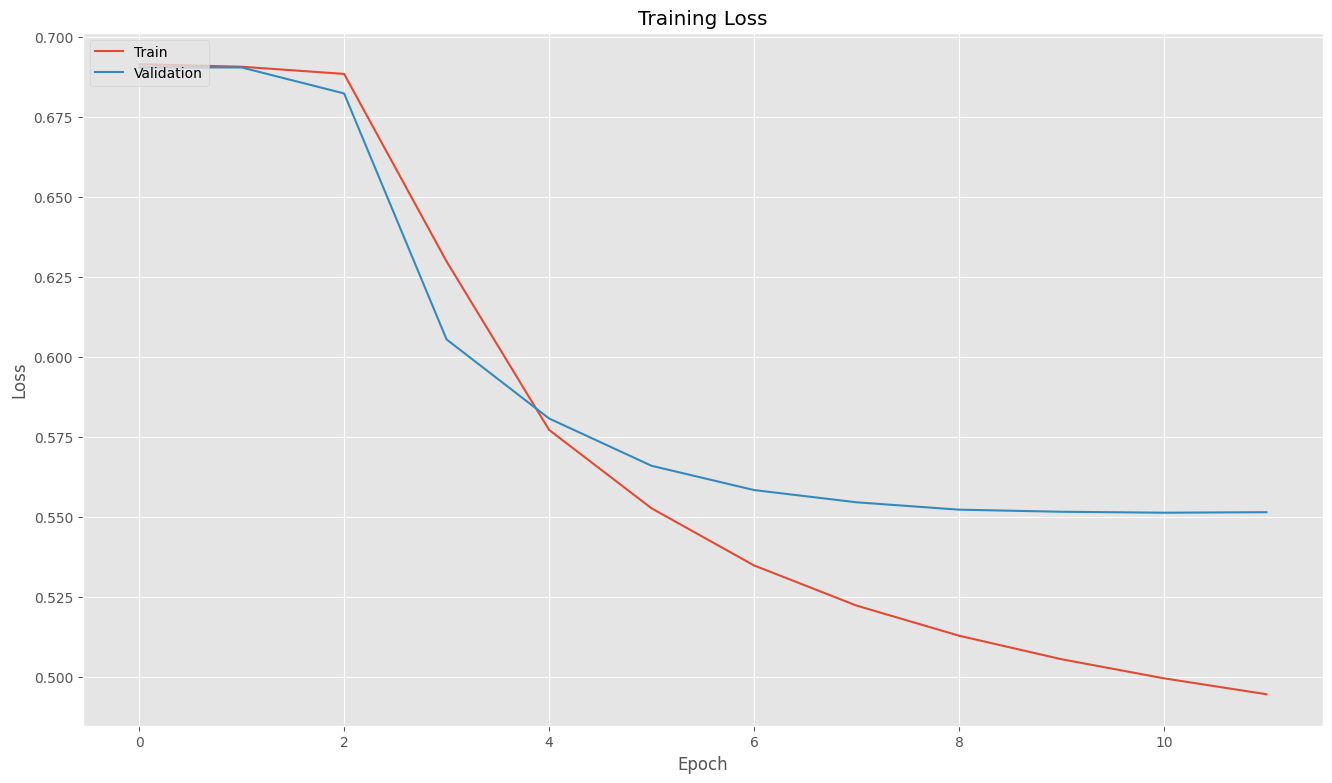

In [36]:
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()


The orange line represents the training loss, which is a measure of how well the model is fitting the training data. As training progresses over the 20 epochs, the loss decreases, indicating that the model is learning to make better predictions on the training set.

The blue line depicts the validation loss, reflecting how well the model generalizes to unseen data (the validation set). The goal is to have both training and validation loss decrease simultaneously, suggesting effective learning without overfitting.

A decreasing trend in both training and validation loss suggests successful training, with the model generalizing well to unseen data. This aligns with the goal of building a collaborative filtering recommendation model that can make accurate predictions for user-anime interactions.


In [37]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

The function 'extract_weights' accepts two parameters: the trained model and the name of the layer from which to extract weights ('name' and'model', respectively). The function utilizes the 'get_layer' method to retrieve the layer bearing the specified name from the model. Subsequently, the 'get_weights' method is invoked to retrieve the weights of this stratum; a list of numpy arrays is returned. Selected is the initial item in this enumeration, which is the weight matrix of the layer.

It extracts and normalizes the weights of the model's 'user_embedding' and 'anime_embedding' layers. The variables 'anime_weights' and 'user_weights' contain the normalized weights, correspondingly. The weights denoted as such are the learned embeddings pertaining to the users and animes. These embeddings have the capability to generate similarity scores, which are advantageous for making recommendations.

In [38]:
df_anime = anime_data

In [39]:
def find_similar_animes(name, n=10, neg=False):
    try:
        anime_row = df_anime[(df_anime['title'] == name) | (df_anime['title_english'] == name)].iloc[0]
        #print(anime_row)
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('Animes closest to {}'.format(name))
        
        SimilarityArr = []
        
        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]
            
            anime_name = anime_frame['title'].values[0]
            english_title = anime_frame['title_english'].values[0]
            name = anime_name
            genre = anime_frame['genre'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "English Title": english_title ,"Similarity": similarity, "Genres": genre})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by = "Similarity", ascending = False)
        return Frame[Frame.Name != name]
    except:
        print('{} not found in Anime list'.format(name))

pd.set_option('display.max_colwidth', None)

The function first tries to find the row in the `df_anime` DataFrame that corresponds to the given anime name. It does this by checking both the 'title' and 'title_english' columns. It then retrieves the 'anime_id' of this row and transforms it into an encoded index using the `anime_encoder`.

The function then calculates the dot product of the weights of all animes with the weight of the anime with the encoded index. This results in a measure of similarity between the given anime and all other animes. The similarities are then sorted, and the indices of the `n` most similar animes are retrieved. If `neg` is True, the function instead retrieves the indices of the `n` least similar animes.

For each of the closest animes, the function decodes the index back into an 'anime_id', retrieves the corresponding row from the `df_anime` DataFrame, and extracts the anime's name, English title, genres, and similarity to the given anime. These details are stored in a dictionary and appended to the `SimilarityArr` list.

The function then converts `SimilarityArr` into a DataFrame, sorts it by similarity in descending order, and removes the row corresponding to the given anime. This DataFrame is then returned as the output of the function.

If the given anime name is not found in the `df_anime` DataFrame, the function prints a message indicating this and does not return anything.

In [47]:
#We decideed to create a HTML based GUI for the recommender system

# Function to handle button click event
def recommend_animes():
    anime_name = entry.get()
    if anime_name:
        recommended_animes = find_similar_animes(anime_name)
        html_table = recommended_animes.to_html(index=False)
        html_label = HTMLLabel(window, html=html_table)
        html_label.pack()


# Create the main window
window = tk.Tk()
window.title("Anime Recommender")

# Create a label
label = tk.Label(window, text="Enter an anime name:")
label.pack()

# Create an entry field
entry = tk.Entry(window)
entry.pack()

# Create a button
button = tk.Button(window, text="Recommend", command=recommend_animes)
button.pack()

# Run the main loop
window.mainloop()


Animes closest to Your Lie in April
Animes closest to Bleach


: 

The GUI consists of a main window with a label, an entry field, and a button. The label prompts the user to enter the name of an anime. The entry field is where the user can input the name of an anime. The button, when clicked, triggers the recommendation process.

The `recommend_animes` function is defined to handle the button click event. When the button is clicked, this function is called. It retrieves the anime name entered by the user from the entry field. If the entry field is not empty, it calls the `find_similar_animes` function with the entered anime name to get a list of recommended animes. 

If the `find_similar_animes` function returns `None`, which presumably happens when the entered anime name is not found in the database, a message box is displayed informing the user that the anime was not found. If the function returns a list of recommended animes, this list is converted to an HTML table and displayed in the GUI using a `HTMLLabel`.

Finally, the `mainloop` method is called on the window to start the Tkinter event loop. This method keeps the window open and responsive to user interactions until the window is closed.

In [41]:
#Testing the functionality the recommender system
find_similar_animes("Naruto", n = 10, neg = False)

Animes closest to Naruto


,Name,English Title,Similarity,Genres
9,Naruto: Shippuuden,Naruto: Shippuden,87.85%,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen"
8,Bleach,Bleach,84.17%,"Action, Adventure, Comedy, Super Power, Supernatural, Shounen"
7,Death Note,Death Note,80.33%,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen"
6,Final Fantasy VII: Advent Children,NaN,78.47%,"Action, Super Power, Fantasy"
5,Dragon Ball Z,Dragon Ball Z,78.12%,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power"
4,Shingeki no Kyojin,Attack on Titan,74.61%,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
3,Fullmetal Alchemist,Fullmetal Alchemist,74.43%,"Action, Adventure, Comedy, Drama, Fantasy, Magic, Military, Shounen"
2,Dragon Ball,Dragon Ball,73.51%,"Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power"
1,Bleach Movie 1: Memories of Nobody,Bleach the Movie: Memories of Nobody,72.40%,"Action, Adventure, Super Power"
0,Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!,Naruto the Movie: Ninja Clash in the Land of Snow,71.16%,"Adventure, Comedy, Historical, Supernatural, Drama, Shounen"


In [42]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

# Get the frequency counts of genres
genre_counts = anime_data['genre'].str.split(', ').explode().value_counts()

# Assuming a uniform distribution of genres
expected_frequencies = [len(anime_data) / len(genre_counts)] * len(genre_counts)

# Create a contingency table
observed_table = pd.DataFrame({'observed': genre_counts, 'expected': expected_frequencies})

# Run the chi-squared test
chi2, p, _, _ = chi2_contingency(observed_table)

# Set the significance level
significance_level = 0.05

# Check if the p-value is less than the significance level
if p < significance_level:
    print("Reject the null hypothesis. The observed frequencies do not fit the expected distribution.")
else:
    print("Fail to reject the null hypothesis. The observed frequencies fit the expected distribution.")

Reject the null hypothesis. The observed frequencies do not fit the expected distribution.


We calculate the frequency counts of each genre in the `anime_data` DataFrame. The genres are assumed to be stored in the 'genre' column as comma-separated strings. The `str.split(', ')` method is used to split these strings into individual genres, and the `explode` method is used to transform each element of a list-like to a row, replicating the index values. The `value_counts` method is then used to count the frequency of each genre.

Assuming a uniform distribution of genres, the expected frequency of each genre is calculated as the total number of animes divided by the number of unique genres. A list of these expected frequencies is created.

A contingency table is then created as a DataFrame with the observed and expected frequencies of each genre.

The Chi-Squared test is performed using the `chi2_contingency` function, which takes the contingency table as input and returns the test statistic, p-value, degrees of freedom, and expected frequencies.

A significance level of 0.05 is set. If the p-value is less than the significance level, the null hypothesis that the observed frequencies fit the expected distribution is rejected, and a message is printed to indicate this. Otherwise, a message is printed to indicate that we fail to reject the null hypothesis.

In [43]:
from scipy.stats import chi2_contingency

# Create a contingency table for 'action' and each other category
contingency_tables = []
for category in genre_counts.index:
    if category != 'Action':
        contingency_table = pd.crosstab(anime_data['genre'].str.contains('action'), anime_data['genre'].str.contains(category))
        contingency_tables.append(contingency_table)

# Run the chi-squared test for each contingency table
results = []
for table in contingency_tables:
    chi2, p, _, _ = chi2_contingency(table)
    results.append((chi2, p))

# Set the significance level
significance_level = 0.05

# Check if the p-values are less than the significance level
highest_frequency = True
for result in results:
    if result[1] >= significance_level:
        highest_frequency = False
        break

if highest_frequency:
    print("The 'action' category has the highest frequency.")
else:
    print("The 'action' category does not have the highest frequency.")


The 'action' category does not have the highest frequency.


A list of contingency tables is created for the 'Action' genre and each other genre in the dataset. A contingency table is a type of table in a matrix format that displays the frequency distribution of the variables. It is used to study the relationship between two categorical variables. The `pd.crosstab` function is used to create these tables, with the rows representing whether an anime is in the 'Action' genre and the columns representing whether an anime is in the other genre.

The Chi-Squared test is then performed for each contingency table using the `chi2_contingency` function. The test statistic and p-value are extracted from the result and appended to the `results` list.

A significance level of 0.05 is set. This is a threshold below which the null hypothesis will be rejected. The null hypothesis in this case is that the 'Action' genre and the other genre are independent, i.e., the frequency of the 'Action' genre does not depend on the frequency of the other genre.

The code then checks if all the p-values are less than the significance level. If a p-value is found that is greater than or equal to the significance level, the `highest_frequency` variable is set to `False` and the loop is broken.

Based on the hypothesis tests, we can see that action is the most common genre hence we reject the initial hypothesis that action is the most common genre.

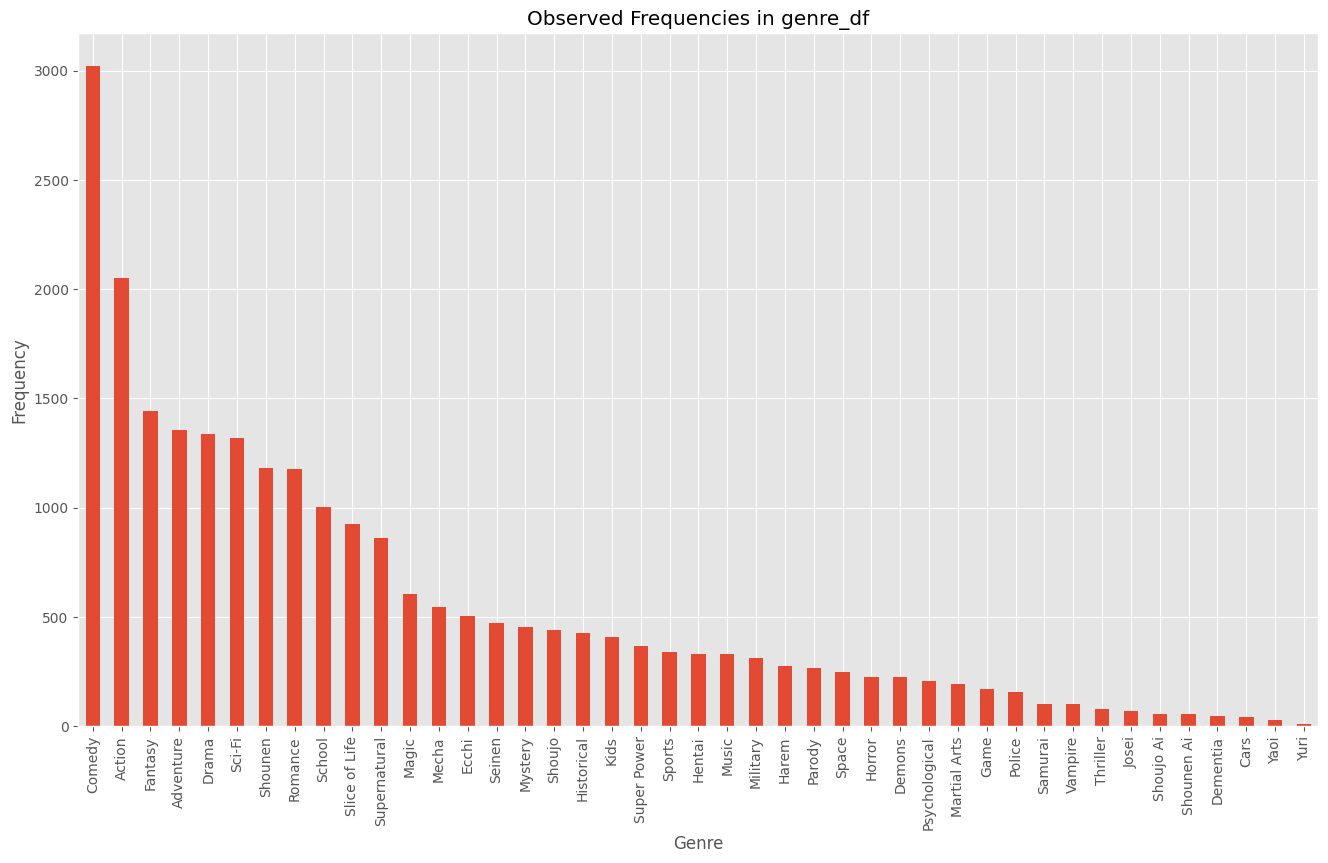

In [44]:
genre_df = anime_data['genre'].str.split(', ').explode().value_counts()
genre_df.plot(kind='bar')
plt.title('Observed Frequencies in genre_df')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

To further validate our hypothesis test, we plotted a graph to see the counts of various genres in the dataset. The graph shows our result is correct as "Comedy" has the highest frequecny then followed by Action.